In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import logging
import wandb
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import os
import numpy as np
import nibabel as nib
import pandas as pd
from torch import Tensor
from pathlib import Path
import logging
import wandb
import torchvision.transforms.functional as TF 
from scipy.special import erf

In [2]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [16]:
import torch  
import torch.nn as nn  
import torch.optim as optim  
from torch.utils.data import DataLoader, Dataset  
from torchvision import transforms  
import numpy as np  
import pandas as pd  
from PIL import Image  
import random  
import torchvision.transforms.functional as TF 
  

summary_file = '../data/NFBS_detailed_summary.csv' 
filtered_df = pd.read_csv(summary_file)

In [35]:
def Img_proc(image, _lambda = -0.8, epsilon = 0.00000001):
    I_img = image
    I_img_norm = (I_img - np.min(I_img)) / (np.max(I_img) - np.min(I_img) + epsilon) 
    
    # Step 1: Compute IMG1
    max_I_img = np.max(I_img_norm)
    IMG1 = (max_I_img / np.log(max_I_img + 1 + epsilon)) * np.log(I_img_norm + 1)
    
    # Step 2: Compute IMG2
    IMG2 = 1 - np.exp(-I_img_norm)
    
    # Step 3: Compute IMG3
    IMG3 = (IMG1 + IMG2) / (_lambda + (IMG1 * IMG2))
    
    # Step 4: Compute IMG4
    IMG4 = erf(_lambda * np.arctan(np.exp(IMG3)) - 0.5 * IMG3)
    
    # Step 5: Compute IMG5 (Normalization)
    min_IMG4 = np.min(IMG4)
    max_IMG4 = np.max(IMG4)
    IMG5 = (IMG4 - min_IMG4) / (max_IMG4 - min_IMG4 + epsilon)
    
    return IMG5

class BrainDataset(Dataset):  
    def __init__(self, dataframe, transform=None):  
        self.dataframe = dataframe  
        self.transform = transform  
  
    def __len__(self):  
        return len(self.dataframe) * self.get_num_slices(self.dataframe.iloc[0]['File Path'])  
  
    def get_num_slices(self, file_path):  
        mri_image = nib.load(file_path)  
        return mri_image.shape[2]  
  
    def __getitem__(self, idx):  
        file_index = idx // self.get_num_slices(self.dataframe.iloc[0]['File Path'])  
        slice_index = idx % self.get_num_slices(self.dataframe.iloc[0]['File Path'])  
        img_path = self.dataframe.iloc[file_index]['File Path']  
        image = self.load_mri_slice(img_path, slice_index)  
  
        if self.transform:  
            image = self.transform(image)  
  
        masked_image, mask = self.add_random_mask(image)  
        return masked_image, image, mask  
  
    def load_mri_slice(self, file_path, slice_index):  
        mri_image = nib.load(file_path)  
        image = mri_image.get_fdata()[:, slice_index, :]  
        image = np.expand_dims(image, axis=0)  # Add channel dimension  
        image = torch.tensor(image, dtype=torch.float32)  
        image = TF.rotate(image, 90)
        
        # Convert back to numpy array for image enhancement  
        image_np = image.squeeze().numpy()  
          
        # Apply image enhancement  
        enhanced_image_np = Img_proc(image_np)  
          
        # Convert back to tensor  
        enhanced_image = torch.tensor(enhanced_image_np, dtype=torch.float32).unsqueeze(0)  
          
        return enhanced_image   
  
    def add_random_mask(self, image):  
        mask = torch.ones_like(image)  
        x = random.randint(0, image.size(1) - 64)  
        y = random.randint(0, image.size(2) - 64)  
        mask[:, x:x+64, y:y+64] = 0  
        masked_image = image * mask  
        return masked_image, mask 

  
# Load the dataset  
dataset = BrainDataset(filtered_df)  
dataloader = DataLoader(dataset, batch_size=20, shuffle=True)

In [20]:
class Discriminator(nn.Module):  
    def __init__(self, in_channels):  
        super(Discriminator, self).__init__()  
        self.model = nn.Sequential(  
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),  
            nn.LeakyReLU(0.2, inplace=True),  
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(128),  
            nn.LeakyReLU(0.2, inplace=True),  
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(256),  
            nn.LeakyReLU(0.2, inplace=True),  
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(512),  
            nn.LeakyReLU(0.2, inplace=True),  
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),  
            nn.Sigmoid()  
        )  
  
    def forward(self, x):  
        return self.model(x)   

In [21]:
# Initialize models  
generator = UNet(n_channels=1, n_classes=1, bilinear=True)  # Assuming grayscale images  
discriminator = Discriminator(in_channels=1)  # For discriminator, in_channels should match the image channels  
  
# Loss functions  
adversarial_loss = nn.BCEWithLogitsLoss()  
l1_loss = nn.L1Loss()  
  
# Optimizers  
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))  
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))  

In [7]:
num_epochs = 10 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
  
generator.to(device)  
discriminator.to(device)  
  
for epoch in range(num_epochs):  
    for i, (masked_images, real_images, masks) in enumerate(dataloader):  
        masked_images = masked_images.to(device)  
        real_images = real_images.to(device)  
        masks = masks.to(device)  
          
        # Train Discriminator  
        optimizer_D.zero_grad()  
          
        # Real images  
        real_preds = discriminator(real_images)  
        real_targets = torch.ones_like(real_preds, device=device)  
        real_loss = adversarial_loss(real_preds, real_targets)  
          
        # Fake images  
        fake_images = generator(masked_images)  
        fake_preds = discriminator(fake_images.detach())  
        fake_targets = torch.zeros_like(fake_preds, device=device)  
        fake_loss = adversarial_loss(fake_preds, fake_targets)  
          
        # Total discriminator loss  
        d_loss = (real_loss + fake_loss) / 2  
        d_loss.backward()  
        optimizer_D.step()  
          
        # Train Generator  
        optimizer_G.zero_grad()  
          
        # Adversarial loss  
        fake_preds = discriminator(fake_images)  
        g_adv_loss = adversarial_loss(fake_preds, real_targets)  
          
        # L1 loss  
        g_l1_loss = l1_loss(fake_images, real_images) * 100  
          
        # Total generator loss  
        g_loss = g_adv_loss + g_l1_loss  
        g_loss.backward()  
        optimizer_G.step()  
          
        print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] "  
              f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")  
      
    # Optionally save the model checkpoints  
    if (epoch + 1) % 10 == 0:  
        torch.save(generator.state_dict(), f"generator_epoch_{epoch + 1}.pth")  
        torch.save(discriminator.state_dict(), f"discriminator_epoch_{epoch + 1}.pth")  
  
print("Training finished.")  

[Epoch 0/10] [Batch 0/300] [D loss: 0.7241] [G loss: 5612.3374]


KeyboardInterrupt: 

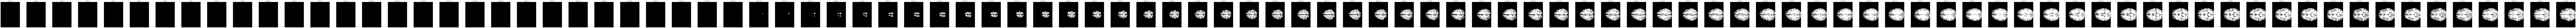

In [36]:
import matplotlib.pyplot as plt  

# Visualize a few 2D slices  
def visualize_slices(dataset, num_slices=100):  
    fig, axes = plt.subplots(1, num_slices, figsize=(500, 5))  
    for i in range(num_slices):  
        masked_image, real_image, mask = dataset[i]  
        axes[i].imshow(real_image.squeeze(), cmap='gray')  
        axes[i].set_title(f'Slice {i}')  
        axes[i].axis('off')  
    plt.show()  
  
visualize_slices(dataset)  